# Tutorial (under construction)

This notebook aims at presenting the basics of how to simulate a of glycogen granule. 


In [82]:
import numpy as np
import glycogen_module as gm
import json
import random
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os, os.path

with open("parameters.json", "r") as f:
    parameters = json.load(f)
    
random.seed(222)

## Description of the parameters:

`GS`, `GBE`, `GDE`, `GP` can be seen as adimensional activities of the corresponding enzymes.  
`number_of_glucose_to_be_fixed` this is the maximal number of glucose that can be fixed during synthesis. When the granule reach this number, the simulation stops

`max_number_of_timestep`: number max of iterations in a simulation  

`number_of_glucose_in_the_system`: not used in the paper, it is useful when one wants to investigate the synthesis under a limited amount of glucose

`size_spec_xxx`: chain length specificities for different enzymes (see paper)

`model_for_gbe`: different ways to branch can be investigated. It will provide one branching model to the branching reaction. 

`b`: is the radius of the glucose sphere. The unit is dimensionless but corresponds to $5.4$ times the rise per turn of the glucose inside an helical configuration. We normalized the rise per turn to 1 which corresponds to $0.24$ nm. Therefore $5.4$ corresponds to $1.3$ nm

`r_GN` the radius of the glycogenin core in multiple of rise per turn

In [83]:
print(parameters)

{'GBE': 1.0, 'GS': 0.2, 'GDE': 0.0, 'GP': 0.0, 'number_of_glucose_to_be_fixed': 5000, 'max_number_of_timestep': 50, 'number_of_glucose_in_the_system': 5000, 'size_spec_gys': 2, 'size_spec_pygl': 2, 'size_spec_gbe_spacing': 1, 'size_spec_gbe_leftover': 3, 'size_spec_gbe_transferred': 3, 'size_spec_gde': 3, 'model_for_gbe': 'flexible_location_model', 'b': 5.4, 'r_GN': 11.87}


## Intitializing a granule

`glycogen_structure` takes 3 entries: a dictionary containing the parameters, the number of initial chains (here 2), and the distances between glucoses in a chain that we set to 1 (which corresponds, again, to $0.24$ nm)

NB: This should be placed in the parameters instead as being arguments.
Also, changing theses values might lead to errors since I didn't add the possibilities to change the number of initial chains.

In [84]:
my_granule = gm.glycogen_structure(parameters, 2,1)

print(my_granule.information)

{'chain0': {'identity': 0, 'status': 2, 'generation': 0, 'identity_of_mother': None, 'identity_of_daughter': [], 'position_of_daughter': [], 'glucose_location': [[0, 0, 11.87], [0, 0, 12.87], [0, 0, 13.87], [0, 0, 14.87], [0, 0, 15.87]]}, 'chain1': {'identity': 1, 'status': 2, 'generation': 0, 'identity_of_mother': None, 'identity_of_daughter': [], 'position_of_daughter': [], 'glucose_location': [[0, 0, -11.87], [0, 0, -12.87], [0, 0, -13.87], [0, 0, -14.87], [0, 0, -15.87]]}}


### my_granule.information

This method returns a dictionary that contains all information about the structure. The keys of the dictionary are "chains", which are also dictionaries. Each chain contains various keys that track the information about their identity, status, connectivities with "daughter" and "mother" chains as well as the location of their glucose residues in space.

In [85]:
### Access the location of the glucose in the chain called 'chain1':

list_of_glucose = my_granule.information['chain1']['glucose_location']
print(list_of_glucose)

[[0, 0, -11.87], [0, 0, -12.87], [0, 0, -13.87], [0, 0, -14.87], [0, 0, -15.87]]


Each element in this list is the 3D coordinates of a glucose unit [x,y,z]

At first, the chains are initialized in two opposite directions, starting from `+r_GN` and `-r_GN` on the $z$ axis

## Visualisation

The granule object contains a ploting method to visualise the structure:

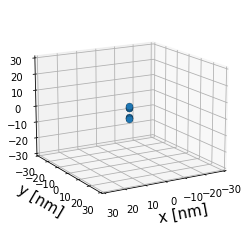

In [86]:
my_granule.plot_structure()

Although it is a bit small to discrimate the glucoses units, we can see the two chains on the z axis pointed in different directions. 

## Looking at the chain status:

In the `my_granule.information` dictionary, chains have an attribute called 'status'. This status is an integer number that will allow a classification of the chains in different groups depending on their chain lengths.

'status' can take the following values : 1,2,3

**status = 1 :** The free part of the chain is really short and is subject only to elongation (enzyme GS)
"really short" is fixed by the mechanistic rules given for the enzymes in the parameter dictionary through the `size_spec` values
Substrate for : GS

**status = 2 :** The chains can be seen as of "intermediary" size. This means that there are long enough to be degraded (enzyme GP), too long to be debranched (GDE), and too short to be branched (GBE). 
Substrate for: GS, GP

**status = 3** : The chains are "long". This means that there are long enough to be branched (GDE), but also to be elongated and degraded (GS and GP), and again, too long to be debranched (GDE). 
Substrate for: GS, GP, GBE.

**status = 4 :** The chain is really short **AND** does not have any branching points. It is therefore subject both to elongation (enzyme GS) and debranching (enzyme GDE)
Substrate for : GS, GDE

This status is then used to determine the substrate pool of each reaction using methods starting with `my_granule.Find_chain_for_xxx()`

In [87]:
print(
'substrate for elongation:' , my_granule.Find_chain_for_gs(),'\n',
'substrate for branching:' , my_granule.Find_chain_for_gbe(),'\n',
'substrate for reduction:' , my_granule.Find_chain_for_gp(),'\n',
'substrate for debranching:' , my_granule.Find_chain_for_gde(),'\n'
)

substrate for elongation: [0, 1] 
 substrate for branching: [] 
 substrate for reduction: [0, 1] 
 substrate for debranching: [] 



This means that right after initialisation, the chains are only subject to encounter elongation or reduction reactions. There are too long to be unbranched, too short to be branched.

*(NB : Error might raise when one wants to degrade this initial chains. I always forbid reduction when the granule is composed of less that 10/12 glucoses units to avoid this problem)*

## Incorporating glucoses:

The first thing we can two at first is to elongate the chains, because they are too short to be substrate for branching.

Let's fix 30 glucose units and see what happens. For this purpose, we will use the methods `Act_gs()` which will try to add a glucose unit on top of a chain.

Initial number of glucose: 10 

Final number of glucose: 40 



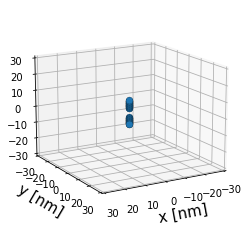

In [88]:
print(
'Initial number of glucose:' , my_granule.number_of_glucose_fixed(),'\n',    
)
for k in range(30):
    my_granule.Act_gs()
    
print(
'Final number of glucose:' , my_granule.number_of_glucose_fixed(),'\n',    
)

my_granule.plot_structure()

### We can now look if the status of the chains changed:


In [89]:
print(
'substrate for elongation:' , my_granule.Find_chain_for_gs(),'\n',
'substrate for branching:' , my_granule.Find_chain_for_gbe(),'\n',
'substrate for reduction:' , my_granule.Find_chain_for_gp(),'\n',
'substrate for debranching:' , my_granule.Find_chain_for_gde(),'\n'
)

substrate for elongation: [0, 1] 
 substrate for branching: [0, 1] 
 substrate for reduction: [0, 1] 
 substrate for debranching: [] 



We can see that the two chains with identity "0" and "1" are substrate for branching.

Lets try to branch:

NB: Here there is a possibility that the attempt to branch does not work. If the proposed location of the new branch occupied a place already occupied, the branching is rejected to avoid overlapping. 

Therefore we will try to branch until the chains can not be branched anymore

In [90]:
print(
'Initial number of chains:' , my_granule.number_of_chain(),'\n',    
)


while  len(my_granule.Find_chain_for_gbe()) > 0:
    condition = my_granule.Act_gbe_flexible_model()
    
print(
'Final number of chains:' , my_granule.number_of_chain(),'\n',    
)


Initial number of chains: 2 

Final number of chains: 7 



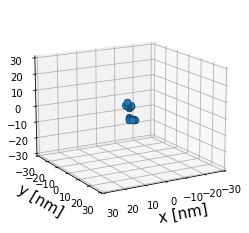

In [91]:
my_granule.plot_structure()

## Forced degradation



In [92]:
print(
'substrate for elongation:' , my_granule.Find_chain_for_gs(),'\n',
'substrate for branching:' , my_granule.Find_chain_for_gbe(),'\n',
'substrate for reduction:' , my_granule.Find_chain_for_gp(),'\n',
'substrate for debranching:' , my_granule.Find_chain_for_gde(),'\n'
)

substrate for elongation: [0, 1, 2, 3, 4, 5, 6] 
 substrate for branching: [] 
 substrate for reduction: [0, 1, 2, 3, 4, 5, 6] 
 substrate for debranching: [] 



All of the chains must be, at this stage, the substrate for elongation and reduction. 
Lets force the reduction:


Initial number of glucose: 40 

Final number of glucose: 23 



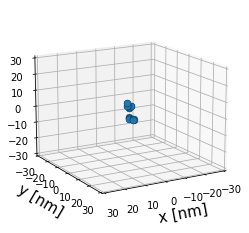

In [93]:
print(
'Initial number of glucose:' , my_granule.number_of_glucose_fixed(),'\n',    
)
while len(my_granule.Find_chain_for_gp()) > 0:
    my_granule.Act_gp()
    
print(
'Final number of glucose:' , my_granule.number_of_glucose_fixed(),'\n',    
)

my_granule.plot_structure()

In [94]:
print(
'substrate for elongation:' , my_granule.Find_chain_for_gs(),'\n',
'substrate for branching:' , my_granule.Find_chain_for_gbe(),'\n',
'substrate for reduction:' , my_granule.Find_chain_for_gp(),'\n',
'substrate for debranching:' , my_granule.Find_chain_for_gde(),'\n'
)

substrate for elongation: [0, 1, 2, 3, 4, 5, 6] 
 substrate for branching: [] 
 substrate for reduction: [] 
 substrate for debranching: [3, 6] 



**All the chains have been shortened to their minimum, further degradation requires debranching enzyme**

At this stage, all of the chains have been reduced until their minimum size, defined in the parameters dictionary.
They can be either debranched or elongated.
Lets force debranching:

In [95]:
print(
'Initial number of chains:' , my_granule.number_of_chain(),'\n',    
)


while  len(my_granule.Find_chain_for_gde()) > 0:
    #print('AVANT',my_granule.information)
    condition = my_granule.Act_gde()

    
print(
'Final number of chains:' , my_granule.number_of_chain(),'\n',    
)


Initial number of chains: 7 

Final number of chains: 5 



In [96]:
print(
'Final number of glucose:' , my_granule.number_of_glucose_fixed(),'\n',    
)

Final number of glucose: 21 



Since a debranching release one glucose, the final number of glucose should be the number of glucose after the reduction, proceed by GP, minus the number of debranched chains.

Here using the same random seed, it must be 23 - 2 = 21

In [97]:
print(
'substrate for elongation:' , my_granule.Find_chain_for_gs(),'\n',
'substrate for branching:' , my_granule.Find_chain_for_gbe(),'\n',
'substrate for reduction:' , my_granule.Find_chain_for_gp(),'\n',
'substrate for debranching:' , my_granule.Find_chain_for_gde(),'\n'
)

substrate for elongation: [0, 1, 2, 4, 5] 
 substrate for branching: [] 
 substrate for reduction: [2, 5] 
 substrate for debranching: [] 



Initial number of glucose: 21 

Final number of glucose: 16 



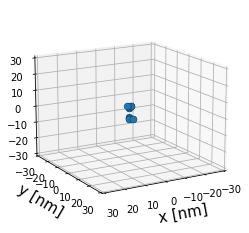

In [98]:
print(
'Initial number of glucose:' , my_granule.number_of_glucose_fixed(),'\n',    
)
while len(my_granule.Find_chain_for_gp()) > 0:
    my_granule.Act_gp()
    
print(
'Final number of glucose:' , my_granule.number_of_glucose_fixed(),'\n',    
)

my_granule.plot_structure()

In [99]:
print(
'substrate for elongation:' , my_granule.Find_chain_for_gs(),'\n',
'substrate for branching:' , my_granule.Find_chain_for_gbe(),'\n',
'substrate for reduction:' , my_granule.Find_chain_for_gp(),'\n',
'substrate for debranching:' , my_granule.Find_chain_for_gde(),'\n'
)

substrate for elongation: [0, 1, 2, 4, 5] 
 substrate for branching: [] 
 substrate for reduction: [] 
 substrate for debranching: [2, 5] 



In [100]:
print(
'Initial number of chains:' , my_granule.number_of_chain(),'\n',    
)


while  len(my_granule.Find_chain_for_gde()) > 0:
    #print('AVANT',my_granule.information)
    condition = my_granule.Act_gde()

    
print(
'Final number of chains:' , my_granule.number_of_chain(),'\n',    
)


Initial number of chains: 5 

Final number of chains: 3 



Initial number of glucose: 14 

Final number of glucose: 7 



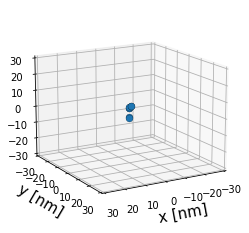

In [101]:
print(
'Initial number of glucose:' , my_granule.number_of_glucose_fixed(),'\n',    
)
while len(my_granule.Find_chain_for_gp()) > 0:
    my_granule.Act_gp()
    
print(
'Final number of glucose:' , my_granule.number_of_glucose_fixed(),'\n',    
)

my_granule.plot_structure()

In [102]:
print(
'substrate for elongation:' , my_granule.Find_chain_for_gs(),'\n',
'substrate for branching:' , my_granule.Find_chain_for_gbe(),'\n',
'substrate for reduction:' , my_granule.Find_chain_for_gp(),'\n',
'substrate for debranching:' , my_granule.Find_chain_for_gde(),'\n'
)

substrate for elongation: [0, 1, 4] 
 substrate for branching: [] 
 substrate for reduction: [] 
 substrate for debranching: [1, 4] 



## Trying to debranche one of the two primary chains lead to an error.

Should add a criteria where one cannot debranches the two primary chains

In [103]:
print(
'Initial number of chains:' , my_granule.number_of_chain(),'\n',    
)


while  len(my_granule.Find_chain_for_gde()) > 0:
    #print('AVANT',my_granule.information)
    condition = my_granule.Act_gde()

    
print(
'Final number of chains:' , my_granule.number_of_chain(),'\n',    
)


Initial number of chains: 3 



KeyError: 'chainNone'